In [1055]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import csv
import json
from config import api_key

In [1056]:
mlb_kaggle = 'Resources/mlb_elo.csv'
team_name_csv = 'output_data/team_name.csv'
team_standings_csv = 'output_data/team_standings.csv'

In [1057]:
# Kaggle csv data on MLB 
kag_latest_df = pd.read_csv(mlb_kaggle_latest)
kag_og_df = pd.read_csv(mlb_kaggle)
kag_og_df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2021-10-03,2021,0,NaN,ATL,NYM,1520.302033,1511.617803,0.546898,0.453102,...,NaN,NaN,NaN,NaN,0.514740,0.485260,NaN,NaN,NaN,NaN
1,2021-10-03,2021,0,NaN,STL,CHC,1519.691110,1525.797177,0.525729,0.474271,...,NaN,NaN,NaN,NaN,0.527320,0.472680,NaN,NaN,NaN,NaN
2,2021-10-03,2021,0,NaN,SEA,ANA,1479.484611,1478.455457,0.535958,0.464042,...,NaN,NaN,NaN,NaN,0.499610,0.500390,NaN,NaN,NaN,NaN
3,2021-10-03,2021,0,NaN,LAD,MIL,1579.554567,1502.598988,0.641331,0.358669,...,NaN,NaN,NaN,NaN,0.646189,0.353811,NaN,NaN,NaN,NaN
4,2021-10-03,2021,0,NaN,KCR,MIN,1473.202406,1498.953739,0.497480,0.502520,...,NaN,NaN,NaN,NaN,0.472238,0.527762,NaN,NaN,NaN,NaN


In [1058]:
# Truncate kaggle MLB csv by season

filtered_data = kag_og_df[(kag_og_df['season'] >= 1910) & (kag_og_df['season'] <= 2019)]
filtered_data.tail()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
192705,1910-04-14,1910,0,NaN,MIN,OAK,1436.723,1543.863,0.382585,0.617415,...,NaN,NaN,NaN,NaN,0.387556,0.612444,1439.717,1540.900,3.0,0.0
192706,1910-04-14,1910,0,NaN,DET,CLE,1549.124,1490.938,0.616117,0.383883,...,NaN,NaN,NaN,NaN,0.617890,0.382110,1546.643,1493.450,7.0,9.0
192707,1910-04-14,1910,0,NaN,CIN,CHC,1498.436,1572.183,0.428894,0.571106,...,NaN,NaN,NaN,NaN,0.431664,0.568336,1499.995,1570.550,1.0,0.0
192708,1910-04-14,1910,0,NaN,CHW,BAL,1517.043,1467.871,0.603773,0.396227,...,NaN,NaN,NaN,NaN,0.607540,0.392460,1518.737,1465.984,3.0,0.0
192709,1910-04-14,1910,0,NaN,ATL,SFG,1444.007,1536.134,0.403195,0.596805,...,NaN,NaN,NaN,NaN,0.408570,0.591430,1445.696,1534.560,3.0,2.0


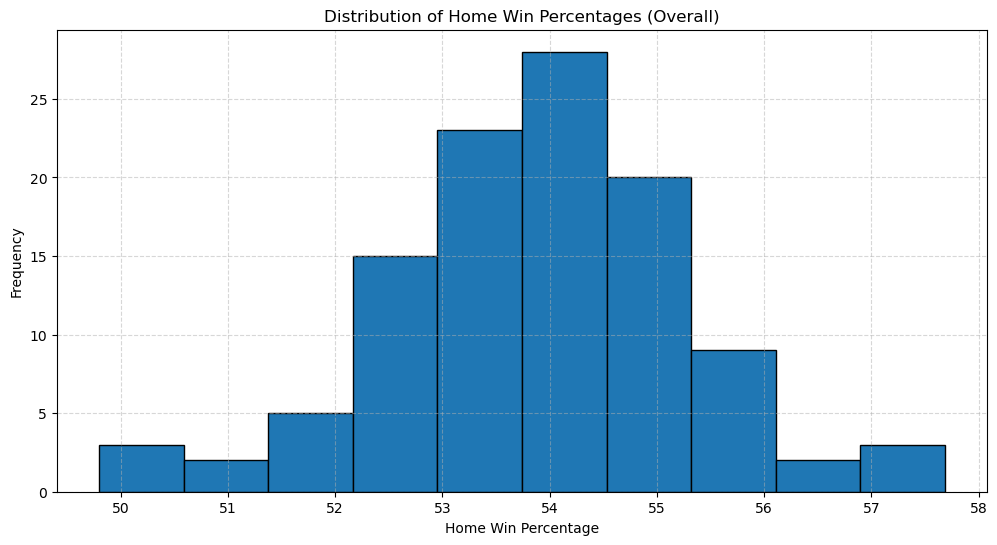

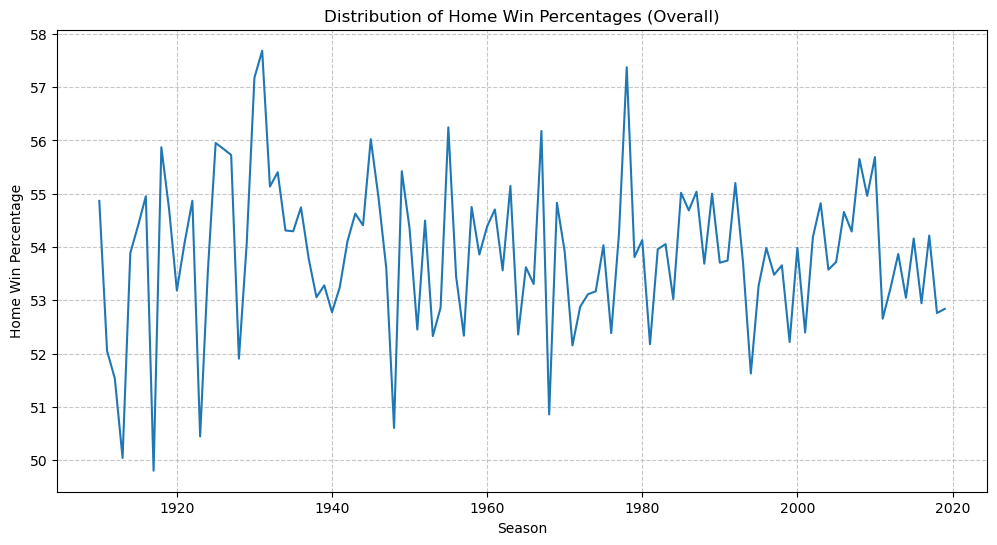

In [1059]:
# create function that plots histogram and line graph of % home wins vs season
# Function takes in dataframe, graph title variable and two firgure variables
# total number of games y axis x axis seasons
def home_team_advantage(filtered_data, graph_title, fig1, fig2):
   
    # Create new dataframe with season, home score, and away score
    
    home_clean_df = pd.DataFrame({
        'season': filtered_data['season'],
        'home score': filtered_data['score1'].astype(int),
        'away score': filtered_data['score2'].astype(int),
        'home team': filtered_data['team1'],
        'away team': filtered_data['team2']

    })
    
    # Check if home score is greater than away score
    
    home_clean_df['Home Win'] = (
        home_clean_df['home score'] > home_clean_df['away score'] )
    
    # Check and count home wins vs away wins

    home_win = home_clean_df[home_clean_df['Home Win'] == True]
    away_win = home_clean_df[home_clean_df['Home Win'] == False]

    home_totals = home_win.groupby('season')['Home Win'].count()
    away_totals = away_win.groupby('season')['Home Win'].count()
    
    # Create total home win vs away win df
    
    totals_df = pd.DataFrame({
        'Home Wins': home_totals,
        'Away Wins': away_totals
    })
    

    # Get total matches

    total_matches = totals_df['Home Wins'] + totals_df['Away Wins']
    
    # Calculate percentage of home wins
    
    home_percentage = (totals_df['Home Wins'] / total_matches) * 100
    home_percentage

    
    # Plot histogram
    plt.figure(figsize=(12, 6))

    plt.hist(home_percentage, edgecolor='black')
    plt.xlabel('Home Win Percentage')
    plt.ylabel('Frequency')  
    plt.title(graph_title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(fig1) 
    plt.show()
    
    # Plot line graph
    plt.figure(figsize=(12, 6))

    plt.plot(home_percentage.index, home_percentage.values, linestyle='-')
    plt.xlabel('Season')
    plt.ylabel('Home Win Percentage')  
    plt.title(graph_title) 
    plt.grid(True, linestyle='--', alpha=0.7) 
    plt.savefig(fig2) 
    plt.show()
    return totals_df


# Create title, fig1, fig2 variables

overall_title = 'Distribution of Home Win Percentages (Overall)'
overall_fig1 = 'output_data/overall_fig1.png'
overall_fig2 = 'output_data/overall_fig2.png'

# Invoke function 

home_percentage_overall = home_team_advantage(filtered_data, overall_title, overall_fig1, overall_fig2)


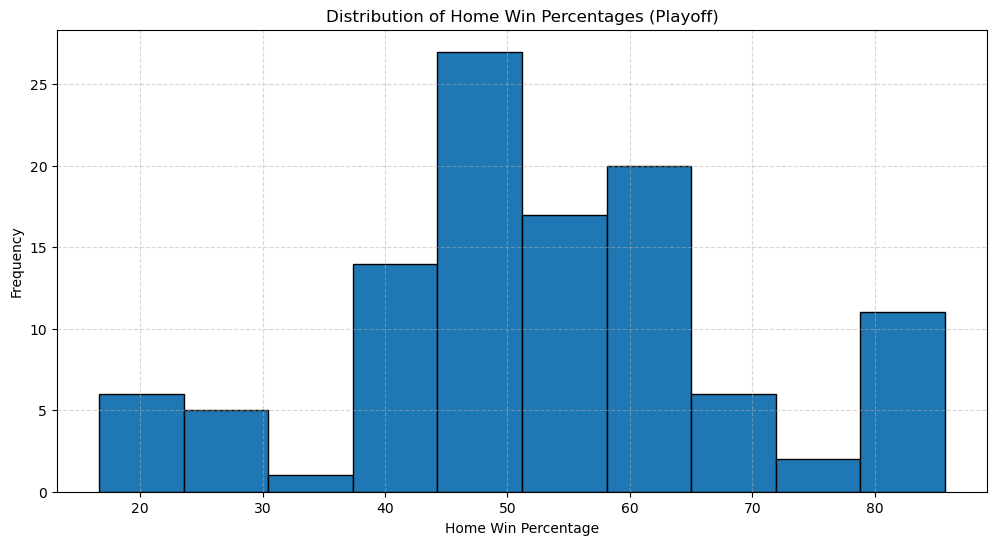

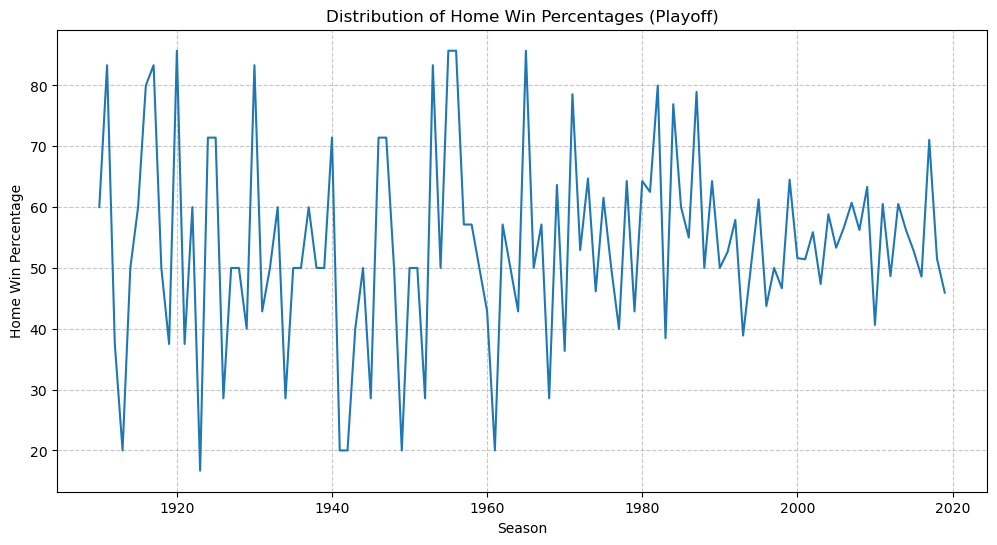

,Home Wins,Away Wins
season,,
1910,3,2
1911,5,1
1912,3,5
1913,1,4
1914,2,2
...,...,...
2015,19,17
2016,17,18
2017,27,11


In [1060]:
# Create df with only playoff data

playoff_df = filtered_data[filtered_data['playoff'].notna()]

# Create title, fig1, fig2 variables

playoff_title = 'Distribution of Home Win Percentages (Playoff)'
playoff_fig1 = 'output_data/playoff_fig1.png'
playoff_fig2 = 'output_data/playoff_fig2.png'

# Invoke function for playoff only 

home_percentage_playoff = home_team_advantage(playoff_df, playoff_title, playoff_fig1, playoff_fig2)
home_percentage_playoff

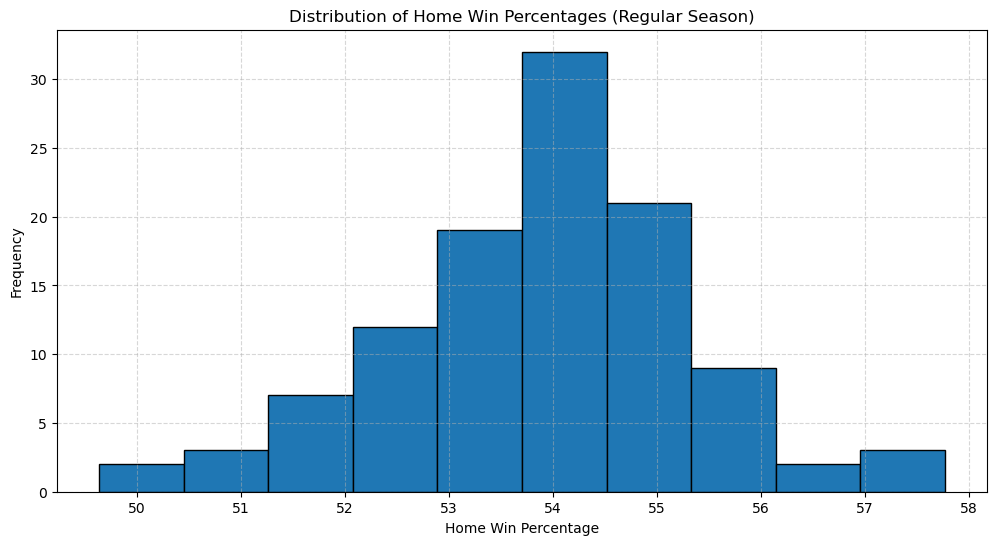

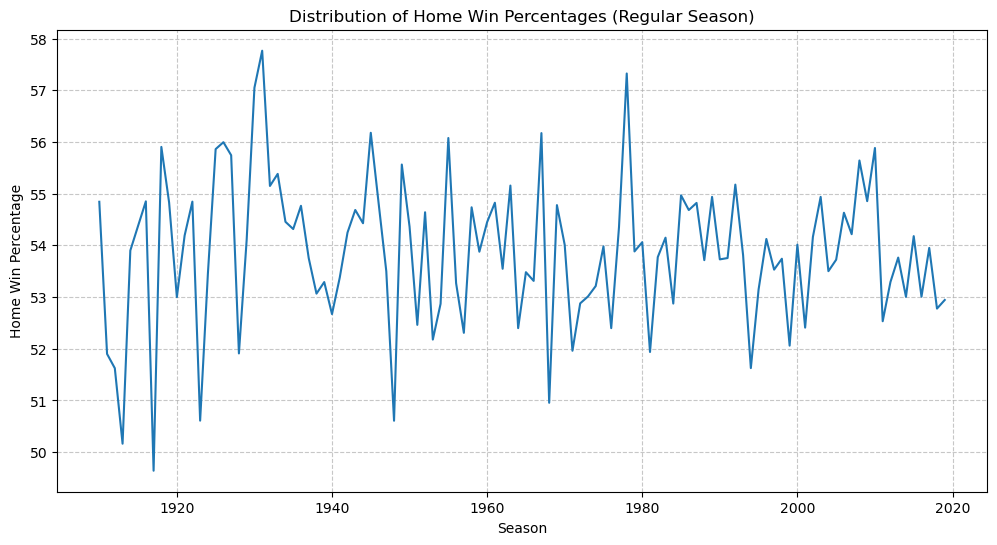

In [1061]:
# Create df with only regular season data

reg_season_df = filtered_data[filtered_data['playoff'].isnull()]

# Create title, fig1, fig2 variables

reg_title = 'Distribution of Home Win Percentages (Regular Season)'
reg_fig1 = 'output_data/reg_fig1.png'
reg_fig2 = 'output_data/reg_fig2.png'

# Invoke function for regular season

home_percentage_season = home_team_advantage(reg_season_df, reg_title, reg_fig1, reg_fig2)

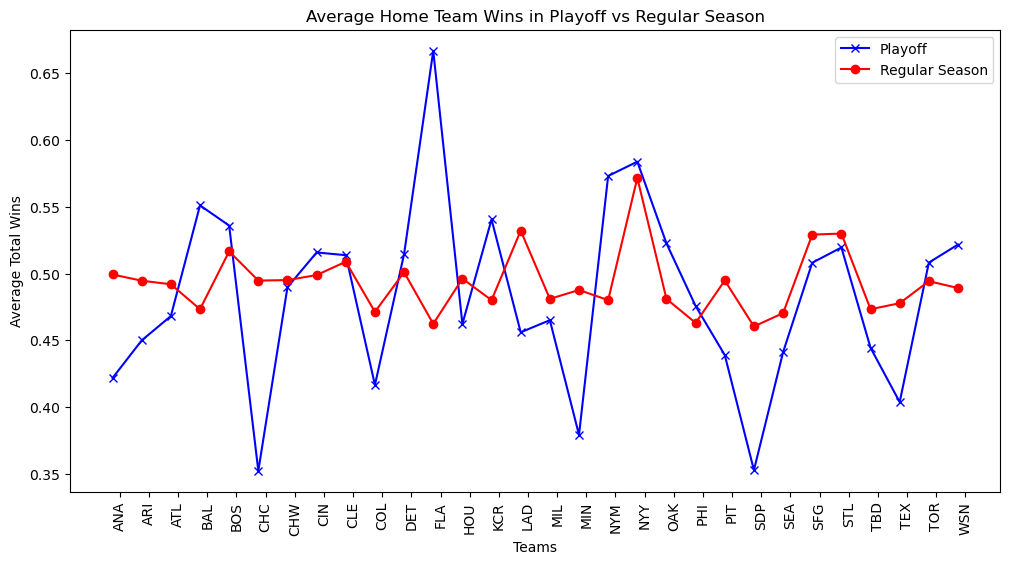

In [1062]:
home_vs_away_df = pd.DataFrame({
    'home playoff': playoff_df['team1'],
    'home playoff score': playoff_df['score1'].astype(int),
    'away playoff': playoff_df['team2'],
    'away playoff score': playoff_df['score2'].astype(int),
    'home regular': reg_season_df['team1'],
    'home regular score': reg_season_df['score1'].astype(int),
    'away regular': reg_season_df['team2'],
    'away regular score': reg_season_df['score2'].astype(int)
})

# Compare playoff and regular home wins against against away wins
# Count total wins in series by counting unique values with value_counts

playoff_games_played = home_vs_away_df['home playoff'].value_counts() + home_vs_away_df['away playoff'].value_counts()
regular_games_played = home_vs_away_df['home regular'].value_counts() + home_vs_away_df['away regular'].value_counts()

playoff_home_wins = home_vs_away_df['home playoff'][home_vs_away_df['home playoff score'] > home_vs_away_df['away playoff score']].value_counts()
playoff_away_wins = home_vs_away_df['away playoff'][home_vs_away_df['away playoff score'] > home_vs_away_df['home playoff score']].value_counts()
regular_home_wins = home_vs_away_df['home regular'][home_vs_away_df['home regular score'] > home_vs_away_df['away regular score']].value_counts()
regular_away_wins = home_vs_away_df['away regular'][home_vs_away_df['away regular score'] > home_vs_away_df['home regular score']].value_counts()

# Add total wins between the playoff and regular home wins series 

playoff_total_wins = playoff_home_wins.add(playoff_away_wins)
regular_total_wins = regular_home_wins.add(regular_away_wins)

# Use .div to determine average

playoff_wins_avg = playoff_total_wins.div(playoff_games_played)
regular_wins_avg = regular_total_wins.div(regular_games_played)

# Set figure size 

plt.figure(figsize=(12, 6))

# Sort indices alphabetically and set the team names 

teams = sorted(set(playoff_total_wins.index) | set(regular_total_wins.index))


# Use .get() on playoff and regular season series to loop through and get win counts


playoff_wins_count_avg = [playoff_wins_avg.get(team) for team in teams]
regular_wins_count_avg = [regular_wins_avg.get(team) for team in teams]

# Plot line graph

plt.plot(teams, playoff_wins_count_avg, marker='x', label='Playoff', color='blue')
plt.plot(teams, regular_wins_count_avg, marker='o', label='Regular Season', color='red')

plt.xlabel('Teams')
plt.ylabel('Average Total Wins')
plt.title('Average Home Team Wins in Playoff vs Regular Season')
plt.xticks([i + 0.5 / 2 for i in range(len(teams))], teams, rotation=90)
plt.legend(loc='best')
plt.savefig('output_data/wins_playoff_vs_reg_line.png')
plt.show()



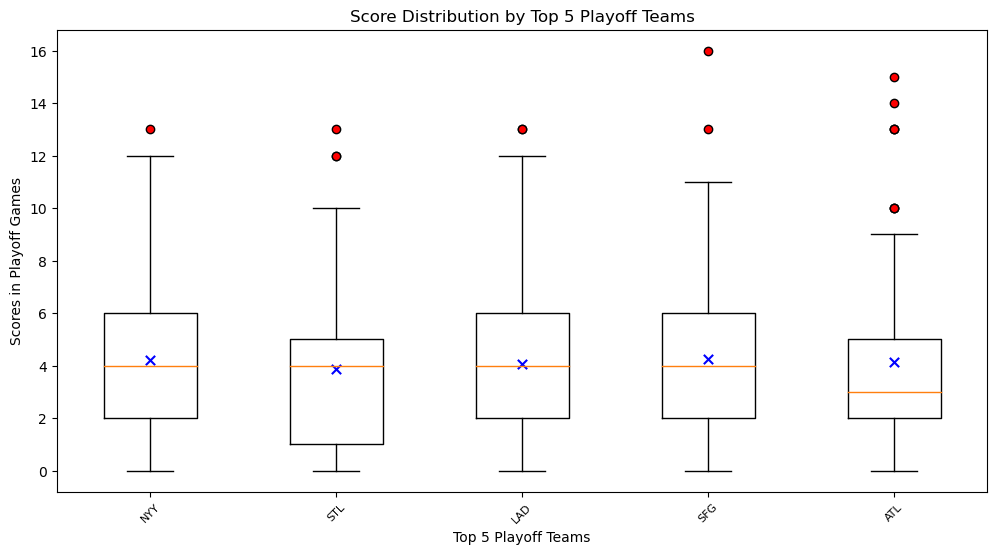

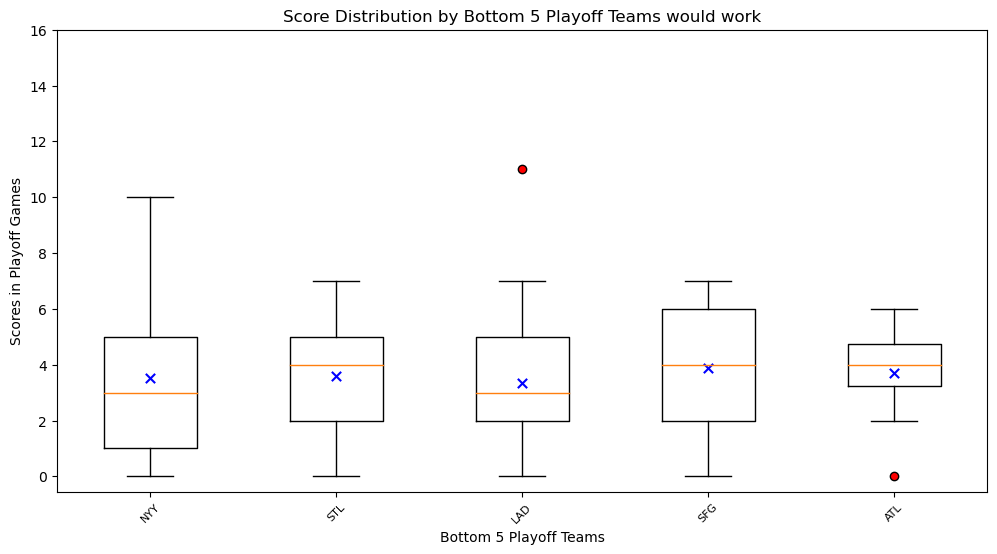

In [1096]:
playoff_summary = playoff_df.groupby('team1')['score1'].agg(['mean', 'median', 'var', 'std', 'sem'])

# Create list of top 5 teams base on total playoff matches counted

top_teams = ['NYY', 'STL', 'LAD', 'SFG', 'ATL']
bottom_teams = ['TBD', 'FLA', 'SEA', 'SDP', 'COL']


def playoff_boxplots(playoff_df, team_list, fig, title, xaxis):
    
    # Create empty score list to append score data

    score_list = []
    
    # Loop through teams list
    
    for team in team_list:

        # Get team 

        team_playoff_data = playoff_df[playoff_df['team1'] == team]

        # Count score at, set quartiles, calculate iqr, upper bounds, lower bounds

        scores_count = team_playoff_data['score1']
        quartiles = scores_count.quantile([0.25,0.75])
        lowerq = quartiles[0.25]
        upperq = quartiles[0.75]
        iqr = upperq - lowerq
        upper_b = upperq + (1.5 * iqr)
        lower_b = lowerq - (1.5 * iqr)

        # Calculate potential outliers by checking if score count is less than lower bound
        # or greater than upper bound

        outliers = scores_count[(scores_count < lower_b) | (scores_count > upper_b)]

        # Append score count to the list

        score_list.append(scores_count)

    # Create box plot

    plt.figure(figsize=(12, 6))
    box_playoff = plt.boxplot(score_list)
    
    # Set and fill outlier marker
    
    for outlier in box_playoff['fliers']:
        outlier.set(marker='o', markerfacecolor='red', markeredgecolor='black')
    
    # Set mean marker
    
    for i, score in enumerate(score_list):
        mean_val = sum(score) / len(score)
        plt.scatter(i + 1, mean_val, marker='x', color='b', s=45)
    plt.xticks(range(1, len(teams_list) + 1), teams_list, rotation=45, fontsize=8)
    plt.yticks(range(0, 18, 2))
    plt.xlabel(xaxis)
    plt.ylabel('Scores in Playoff Games')
    plt.title(title)
    plt.savefig(fig)
    plt.show()
    
box_top_5_fig = 'output_data/box_top_5.png'
box_bottom_5_fig = 'output_data/box_bottom_5.png'
top_5_title = 'Score Distribution by Top 5 Playoff Teams'
bottom_5_title = 'Score Distribution by Bottom 5 Playoff Teams would work'
top_5_x = 'Top 5 Playoff Teams'
bottom_5_x = 'Bottom 5 Playoff Teams'
top_5_teams_playoff = playoff_boxplots(
    playoff_df, top_teams, box_top_5_fig, top_5_title, top_5_x)
bottom_5_teams_playoff = playoff_boxplots(
    playoff_df, bottom_teams, box_bottom_5_fig, bottom_5_title, bottom_5_x)


In [1092]:
# Get API url from sportsdata.io and create endpoint with params

base_url5 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2019?'
base_url6 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2018?'
base_url7 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2017?'
base_url4 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2020?'
base_url3 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2021?'
base_url2 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2022?'
base_url1 = 'https://api.sportsdata.io/v3/mlb/scores/json/Standings/2023?'

params = {
    'key': api_key
}

# Create dictionary that records team city, team, team key and stadium ID

team_standings = {
    'team key':[],
    'league':[],
    'wins':[],
    'runs scored':[],
    'season':[]
}

# Create a function that takes url as an argument and returns all appended api data
# to team standings dictionary 

def standings_append(url):
    
    # Get data from api and save response in json
    
    response = requests.get(url, params=params)
    response = response.json()
    
    # Create team standings dictionary to append api data 
    
    team_standings = {
        'team key': [],
        'league': [],
        'wins': [],
        'runs scored': [],
        'season': []
    }
    
    # Loop through response append data to team_standings dictionary 
    # Return team_standings dictionary with appended data

    for i in range(len(response)):
        league = response[i]['League']
        runs_scored = response[i]['RunsScored']
        key = response[i]['Key']
        wins = response[i]['Wins']
        season = response[i]['Season']

        team_standings['league'].append(league)
        team_standings['runs scored'].append(runs_scored)
        team_standings['team key'].append(key)
        team_standings['wins'].append(wins)
        team_standings['season'].append(season)
    
    return team_standings

def standings_combined(base_urls):
    combined_standings = {
        'team key': [],
        'league': [],
        'wins': [],
        'runs scored': [],
        'season': []
    }
    
    # Loop through the base_url set variable for returned dictionary in standings_append
    # Extend the new season endpoint data to the team_standings keys returned from standings_append
    # Return new dictionary with the extended key values 
    
    for url in base_urls:
        standings_data = standings_append(url)
        for key in standings_combined:
            standings_combined[key].extend(standings_data[key])
    
    return combined_standings

# Combining the data from all base URLs

base_urls = [base_url1, base_url2, base_url3, base_url4, base_url5, base_url6,  base_url7]
team_standings_combined = merge_standings(base_urls)


team_standings_combined = pd.DataFrame(team_standings_combined)
team_standings_combined.to_csv('output_data/team_standings.csv', index=False) 
team_standings_combined.head()


,team key,league,wins,runs scored,season
0,MIN,AL,87,778,2023
1,DET,AL,78,661,2023
2,CLE,AL,76,662,2023
3,CHW,AL,61,641,2023
4,KC,AL,56,676,2023


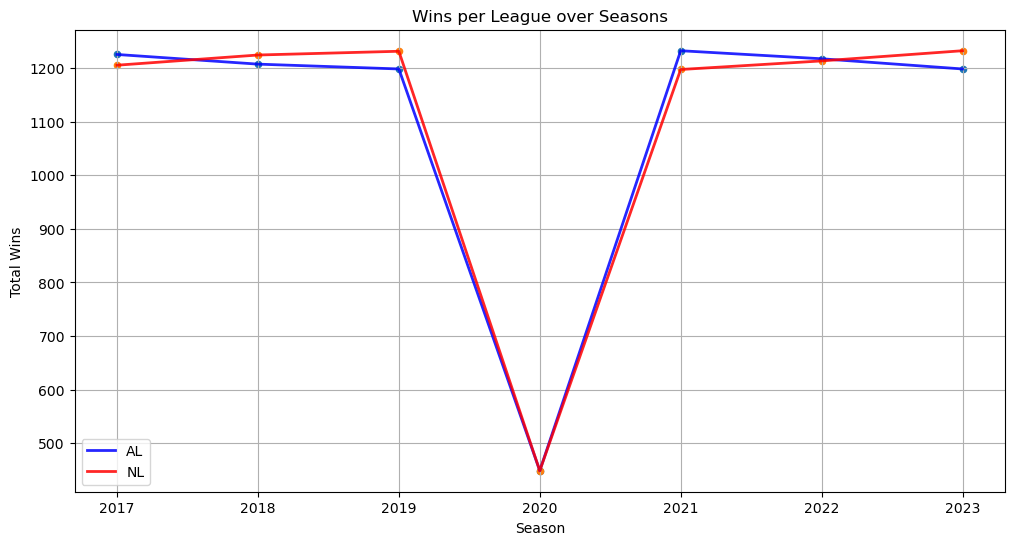

In [1065]:
leagues = team_standings_combined['league'].unique()

# Create a dictionary to store wins for each league over the seasons

league_wins = {}
color = ['blue', 'red']

# Calculate wins for each league over the seasons
plt.figure(figsize=(12, 6))

for league in leagues:
    league_data = team_standings_combined[team_standings_combined['league'] == league]
    total_wins = league_data.groupby('season')['wins'].sum()
    league_wins[league] = total_wins

# Loop through league_wins set label as league value and plot wins at index and values  
# Set line color at index value 
    
for i, (league, wins) in enumerate(league_wins.items()):
    plt.plot(wins.index, wins.values, label=league, linewidth=2, alpha=0.85, color=color[i])
    plt.scatter(wins.index, wins.values, s=20) 

plt.xlabel('Season')
plt.ylabel('Total Wins')
plt.title('Wins per League over Seasons')
plt.legend()
plt.grid(True)
plt.savefig('output_data/wins_per_league_covid.png')
plt.show()

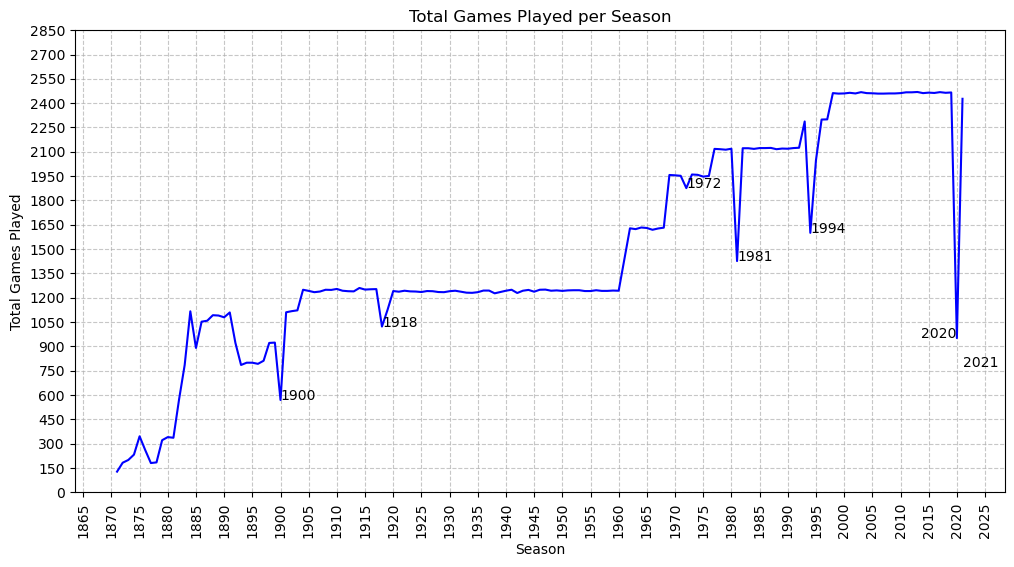

In [1066]:
history_df = pd.DataFrame({
    'season': kag_og_df['season'],
    'home score': kag_og_df['score1'],
    'away score': kag_og_df['score2'],
    'home team': kag_og_df['team1'],
    'away team': kag_og_df['team2']

})

# Check if home score is greater than away score

history_df['Home Win'] = (
    history_df['home score'] > history_df['away score'] )

# Check and count home wins vs away wins

home_win = history_df[history_df['Home Win'] == True]
away_win = history_df[history_df['Home Win'] == False]

home_totals = home_win.groupby('season')['Home Win'].count()
away_totals = away_win.groupby('season')['Home Win'].count()

# Create total home win vs away win df

totals_df = pd.DataFrame({
    'Home Wins': home_totals,
    'Away Wins': away_totals
})

# Get total matches

total_matches = totals_df['Home Wins'] + totals_df['Away Wins']

# Calculate percentage of home wins

home_percentage = (totals_df['Home Wins'] / total_matches) * 100
home_percentage

# plot total matches over seasons
plt.figure(figsize=(12, 6))
plt.plot(total_matches.index, total_matches.values, linestyle='-', color='blue')
plt.xlabel('Season')
plt.ylabel('Total Games Played')
plt.title('Total Games Played per Season')
plt.grid(True, alpha=0.7, linestyle='--')
plt.xticks(range(1865,2030,5),rotation=90, fontsize=10) 
plt.yticks(range(0,3000, 150))
plt.text(1900, 569, str(1900), ha='left', va='baseline', color='black')
plt.text(1918, 1022, str(1918), ha='left', va='baseline', color='black')
plt.text(1972, 1875, str(1972), ha='left', va='baseline', color='black')
plt.text(1981, 1426, str(1981), ha='left', va='baseline', color='black')
plt.text(1994, 1600, str(1994), ha='left', va='baseline', color='black')
plt.text(2020, 951, str(2020), ha='right', va='baseline', color='black')
plt.text(2021, 771, str(2021), ha='left', va='baseline', color='black')
plt.savefig('output_data/history_matches.png')
plt.show()